In [ ]:
!pip install -q transformers[torch] datasets evaluate xformers

## Imports

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments, EvalPrediction, pipeline, set_seed
from datasets import load_dataset, Dataset
import torch
from evaluate import load
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
import itertools

## Global constants

In [ ]:
set_seed(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT = 'Norod78/hebrew-gpt_neo-small'

## Dataset
Load and split the data into train and validation sets

In [ ]:
raw_datasets = load_dataset('csv', data_files=['data/essays.csv', 'data/essays_artificial.csv'], encoding='utf8')
split = raw_datasets['train'].train_test_split(0.1, seed=42, shuffle=True)

Set the labels. Each label corresponds to the native language(L1) of the writer.
- HEB - Hebrew
- ARB - Arabic
- FRA - French
- RUS - Russian
- ART - Artificial

In [ ]:
label2id = {"HEB": 0, "ARB": 1, "FRA":2, "RUS": 3, "ART": 4}
id2label = {v: k for k,v in label2id.items()}

### Perplexity Distributions
Let us use the base model to calculate each essay's perplexity, and use it to build a per-label perplexity distribution to get a sense of the data.

In [ ]:
df = split['train'].to_pandas()
perplexity = load("perplexity", module_type="metric")
label_perplexities = {}
for i in range(5):
    label_data = df[df.label==i]['text'].tolist()
    label_perplexities[i] = perplexity.compute(predictions=label_data, model_id=checkpoint, batch_size=8, device=DEVICE);

Using pad_token, but it is not set yet.


  0%|          | 0/113 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/113 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/113 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/113 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
hist_df = pd.DataFrame()
for label_id in label_perplexities:
 label_df = pd.DataFrame({'perplexity': label_perplexities[label_id]['perplexities'], 'label': id2label[label_id] })
 hist_df = pd.concat([hist_df, label_df])


After visualizating KDE plots of the perplexities, we can see a clear distinction between both the HEB and ART classes vs all the rest.
We can not see a clear distribution difference between ARB,FRA and RUS classes, hence we should use another tool like T test.

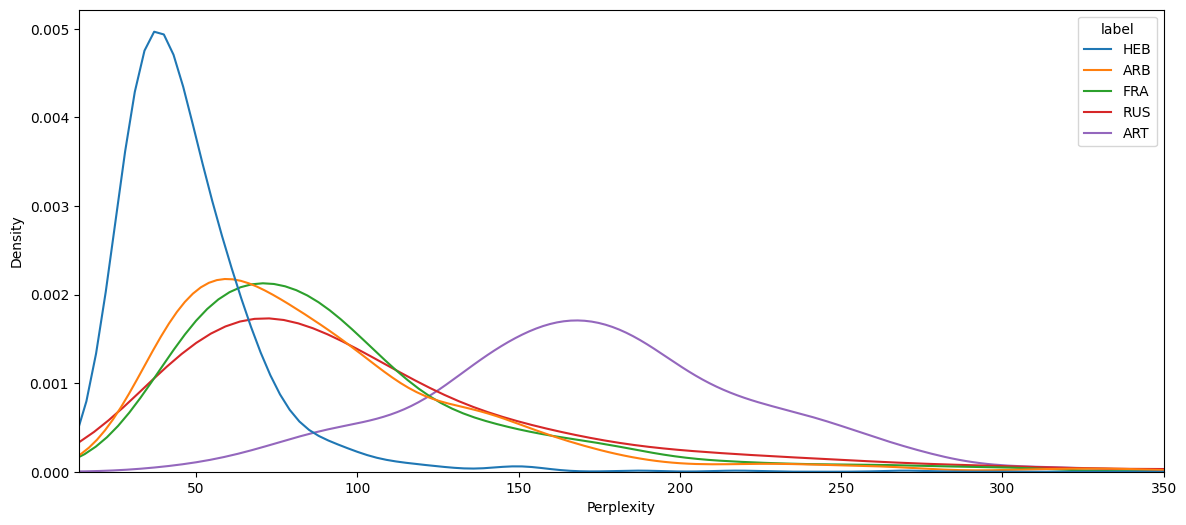

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.set_xlim(hist_df.loc[:,"perplexity"].min(), 350)
sns.kdeplot(data=hist_df, x='perplexity', hue='label', ax=ax);
plt.xlabel('Perplexity')
plt.show();


#### T-test experiment
Here we test whether the ARB, RUS, and FRA perplexities distributions differ from each other, as it cannot be decided visually.

In [ ]:
t_test = ttest_ind(hist_df.loc[hist_df.label!='ART',"perplexity"], hist_df.loc[hist_df.label=='ART',"perplexity"])
print(f"Artificial language Vs all others, P-VALUE: {t_test.pvalue}")


Artificial language Vs all others, P-VALUE: 3.39499812672969e-300


In [ ]:
t_dict = {}
for i in range(1, len(id2label)):
    t_test = ttest_ind(label_perplexities[0]['perplexities'], label_perplexities[i]['perplexities'])
    t_dict[f'HEB_{id2label[i]}'] = t_test.pvalue
pd.Series(t_dict, name='P_VALUE').sort_values(ascending=False).to_frame().T


,HEB_ARB,HEB_RUS,HEB_FRA,HEB_ART
P_VALUE,2.454503e-91,5.415558e-93,3.284203e-104,0.0


In [ ]:
t_table = np.zeros((len(id2label)-1, len(id2label)-1))
for leng1, leng2 in itertools.product(range(1,len(id2label)), repeat=2):
   t_table[leng1-1, leng2-1] = ttest_ind(label_perplexities[leng1]['perplexities'], label_perplexities[leng2]['perplexities']).pvalue
t_df = pd.DataFrame(data=t_table, columns=list(label2id.keys())[1:], index=list(label2id.keys())[1:])
t_df

In [ ]:
sns.heatmap(t_df, annot=True, cmap='viridis')

## Experiments

### Tokenization & Training arguments

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, device=DEVICE)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def tokenizer_fn(batch: Dataset):
    return tokenizer(batch['text'], truncation=True, max_length=1024)

Tokenize the dataset

In [ ]:
tokenized_datasets = split.map(tokenizer_fn, batched=True)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Set training arguments

In [ ]:
training_args = TrainingArguments(
    'trained_model',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8
)

Set evaluation metrics to calculate after each epoch

In [ ]:
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = logits.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)

    return {"f1 score": f1, "accuracy": accuracy}

### Experiment 1 - Different Dropout Rates
Note that we use 5 labels and add a dropout hook

In [ ]:
config = AutoConfig.from_pretrained(CHECKPOINT, label2id=label2id, id2label=id2label, num_labels=5)
propabilities = [0.5, 0.3, 0.1, 0]
for p in propabilities:
    model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, pad_token_id=tokenizer.eos_token_id, num_labels=5,)
    model.score.register_forward_hook(lambda m, inp, out: F.dropout(out, p=p, training=m.training))
    model = model.to(DEVICE)
    training_args.output_dir = f'trained_model_{p}'
    trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )
    trainer.train()

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at Norod78/hebrew-gpt_neo-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 score,Accuracy
1,1.273000,0.507807,0.748579,0.754000
2,0.952300,1.031779,0.719378,0.734000
3,0.851600,0.407990,0.872198,0.874000
4,0.743400,0.364644,0.904355,0.904000
5,0.620100,0.558427,0.902668,0.902000


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at Norod78/hebrew-gpt_neo-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 score,Accuracy
1,1.110900,0.444635,0.802818,0.812000
2,0.655500,0.403997,0.876841,0.878000
3,0.534100,0.393736,0.901931,0.902000
4,0.371600,0.299459,0.921624,0.922000
5,0.265000,0.549861,0.911629,0.912000


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at Norod78/hebrew-gpt_neo-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 score,Accuracy
1,0.792800,0.421138,0.822415,0.820000
2,0.484800,0.509263,0.861328,0.866000
3,0.307900,0.641709,0.878001,0.878000
4,0.172000,0.851046,0.913211,0.914000
5,0.068200,1.002041,0.905899,0.906000


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at Norod78/hebrew-gpt_neo-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 score,Accuracy
1,0.721900,0.549111,0.790059,0.790000
2,0.404300,0.587523,0.846194,0.848000
3,0.253800,0.639231,0.870857,0.872000
4,0.119800,0.654704,0.898003,0.898000
5,0.032800,0.761366,0.891232,0.892000


Load the best trained model using `pipeline`, so we don't have to tokenize the inputs

In [ ]:
saved_model = pipeline('text-classification', model='trained_model_0.3/checkpoint-2252')

Predict the entire test set

In [ ]:
test_preds = saved_model(tokenized_datasets['test']['text'])
preds = [int(p['label'].split('_')[1]) for p in test_preds]

Plot the confusion matrix

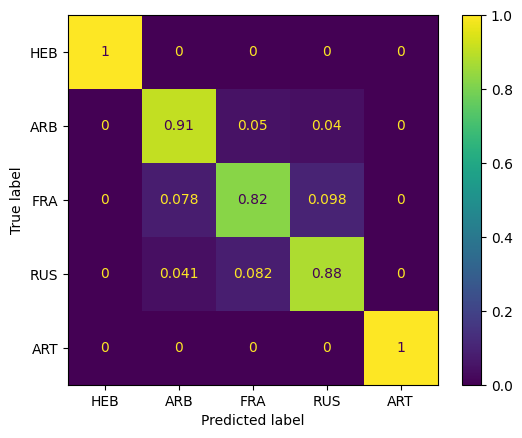

In [ ]:
cm = confusion_matrix(tokenized_datasets['test']['label'], preds, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=label2id.keys()).plot();

### Experiments 2 - Binary Classification
Here we initiate a new 2-class model to try and discriminate between Native vs Non-native writers

re-label the data in a binary way

In [ ]:
df = raw_datasets['train'].to_pandas()
df['label'] = df['label'].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
raw_datasets = Dataset.from_pandas(df)
split = raw_datasets.train_test_split(0.1, seed=42, shuffle=True)

In [ ]:
label2id = {"NAT": 0, "NON": 1}
id2label = {v: k for k,v in label2id.items()}

Tokenize the binary dataset

In [ ]:
tokenized_datasets = split.map(tokenizer_fn, batched=True)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
config = AutoConfig.from_pretrained(CHECKPOINT, label2id=label2id, id2label=id2label, num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, pad_token_id=tokenizer.eos_token_id, num_labels=2)
model.score.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.3, training=m.training))
model = model.to(DEVICE)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at Norod78/hebrew-gpt_neo-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 score,Accuracy
1,0.090500,0.128750,0.983821,0.990000
2,0.124500,0.034347,0.993654,0.996000
3,0.108800,0.000004,1.000000,1.000000
4,0.056800,0.012940,0.996839,0.998000
5,0.065200,0.002052,0.996815,0.998000


TrainOutput(global_step=11250, training_loss=0.12617946183946396, metrics={'train_runtime': 892.3451, 'train_samples_per_second': 25.214, 'train_steps_per_second': 12.607, 'total_flos': 3464134983217152.0, 'train_loss': 0.12617946183946396, 'epoch': 5.0})

In [ ]:
saved_model = pipeline('text-classification', model='trained_model/checkpoint-9000')

In [ ]:
test_preds = saved_model(tokenized_datasets['test']['text'])
preds = [int(p['label'].split('_')[1]) for p in test_preds]

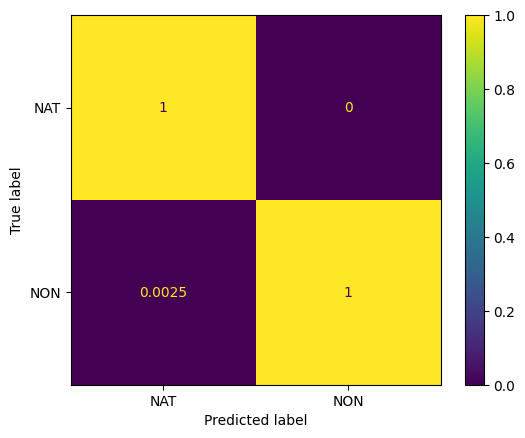

In [ ]:
cm = confusion_matrix(tokenized_datasets['test']['label'], preds, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=label2id.keys()).plot();